# Analysis of memory-pool simulations

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggraph, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(tidygraph, quietly=TRUE)
})

## Adversarial nodes

### Read data

In [2]:
adversaries <- fread("adversaries.tsv.gz", stringsAsFactors=TRUE)
adversaries %>% summary

 Adversarial nodes    Block ID         Txs          Honest txs   
 Min.   :  0.0     B0     : 101   Min.   : 0.00   Min.   : 0.00  
 1st Qu.:120.0     B1     : 101   1st Qu.:60.00   1st Qu.:54.00  
 Median :250.0     B10    : 101   Median :60.00   Median :59.00  
 Mean   :249.2     B11    : 101   Mean   :52.25   Mean   :50.89  
 3rd Qu.:375.0     B12    : 101   3rd Qu.:60.00   3rd Qu.:60.00  
 Max.   :500.0     B13    : 101   Max.   :60.00   Max.   :60.00  
                   (Other):6104                                  
 Adversarial txs 
 Min.   : 0.000  
 1st Qu.: 0.000  
 Median : 1.000  
 Mean   : 1.351  
 3rd Qu.: 2.000  
 Max.   :35.000  
                 

### Raw data at the block level

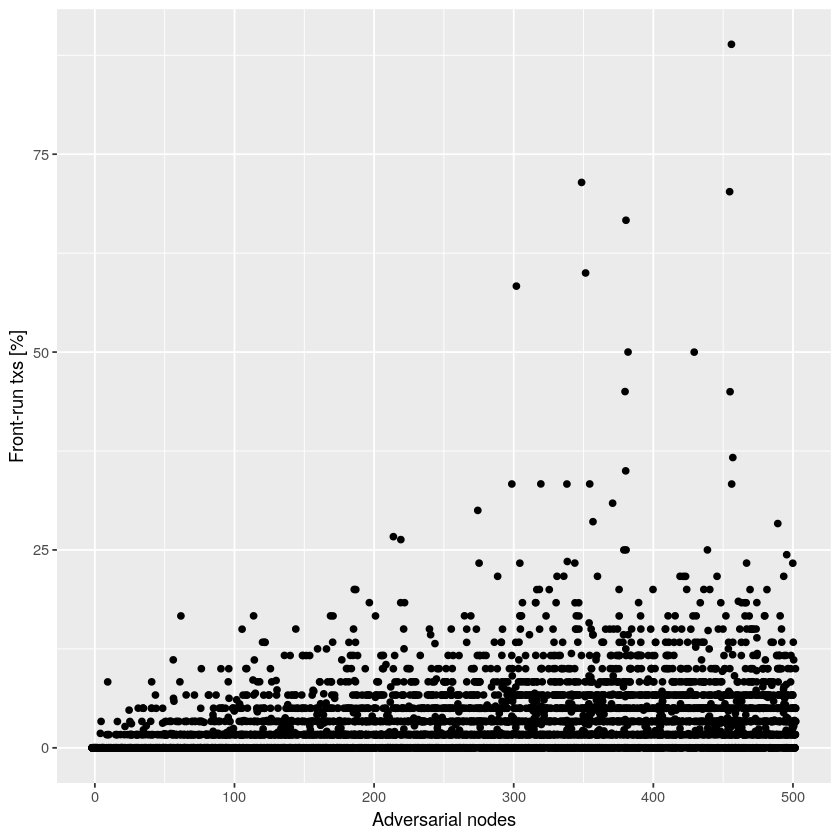

In [3]:
ggplot(
    adversaries[
        `Txs` > 0,
        .(`Front-run txs [%]`=100*sum(`Adversarial txs`)/sum(`Txs`)),
        .(`Adversarial nodes`, `Block ID`)
    ], 
    aes(x=`Adversarial nodes`, y=`Front-run txs [%]`)
) +
    geom_jitter()

### Trends

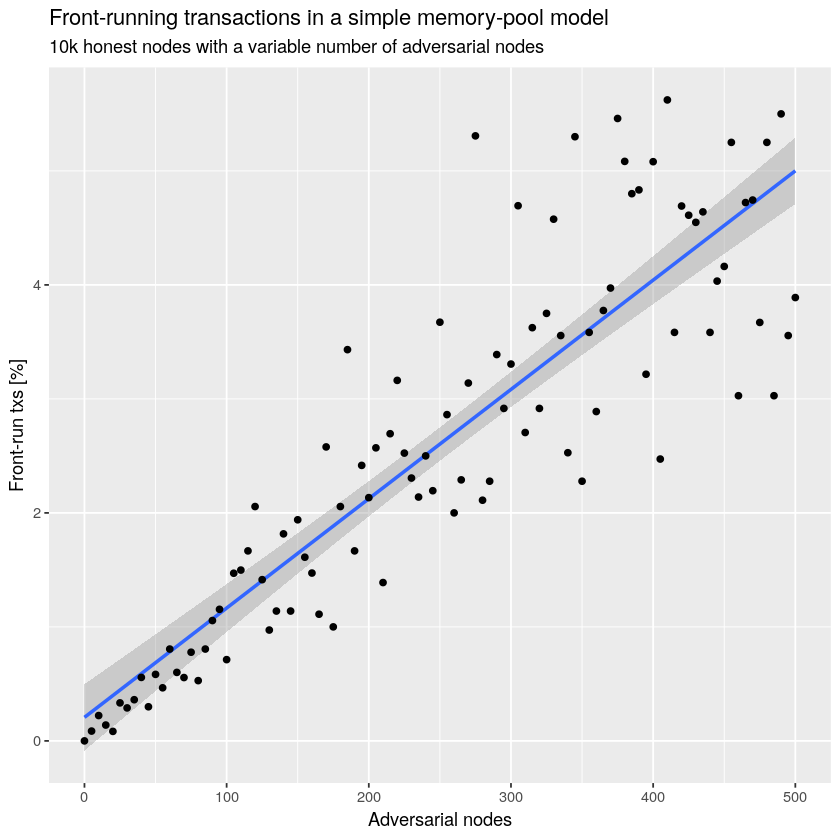

In [4]:
ggplot(
    adversaries[
        ,
        .(`Front-run txs [%]`=100*sum(`Adversarial txs`)/sum(`Txs`)),
        .(`Adversarial nodes`)
    ], 
    aes(x=`Adversarial nodes`, y=`Front-run txs [%]`)
) +
    geom_smooth(formula=y~x, method="lm") +
    geom_point() +
    ggtitle(
        "Front-running transactions in a simple memory-pool model",
        "10k honest nodes with a variable number of adversarial nodes"
    )

In [5]:
ggsave("mempool-scatter.png", units="in", dpi=150, width=8, height=6)

In [6]:
ggsave("mempool-scatter.svg", units="in", dpi=150, width=8, height=6)

## Mempool fragmentation

### Read data file

In [7]:
fragmentation <- fread("fragmentation.tsv.gz", stringsAsFactors=TRUE)
fragmentation %>% summary

     Trial      Time [s]         Node ID             TxId        
 Min.   :0   Min.   :  2.00   H1     :    660   T87    :  36214  
 1st Qu.:0   1st Qu.: 13.00   H10    :    660   T237   :  35869  
 Median :0   Median : 32.00   H100   :    660   T5     :  35782  
 Mean   :0   Mean   : 46.09   H1000  :    660   T327   :  35387  
 3rd Qu.:0   3rd Qu.: 81.00   H10000 :    660   T152   :  35321  
 Max.   :0   Max.   :109.00   H1001  :    660   T98    :  35270  
                              (Other):6595680   (Other):6385797  

### Fragmentation over time and memory pool size

In [8]:
abstract <-
    fragmentation[
        , 
        .(`Nodes`=.N), 
        .(`Trial`, `Time [s]`, `TxId`)
    ][
        ,
        .(
            `Percentile`=factor(c(0, 33, 67, 100)),
            `Nodes`=quantile(`Nodes`, c(0.00, 0.33, 0.67, 1.00)),
            `Txs`=length(unique(`TxId`))
        ),
        .(`Trial`, `Time [s]`)
    ]
abstract %>% summary

     Trial      Time [s]      Percentile     Nodes            Txs       
 Min.   :0   Min.   :  2.00   0  :6      Min.   :    1   Min.   : 60.0  
 1st Qu.:0   1st Qu.: 13.00   33 :6      1st Qu.: 2486   1st Qu.:120.0  
 Median :0   Median : 51.50   67 :6      Median : 7992   Median :210.0  
 Mean   :0   Mean   : 51.33   100:6      Mean   : 6354   Mean   :208.7  
 3rd Qu.:0   3rd Qu.: 81.00              3rd Qu.: 9999   3rd Qu.:300.0  
 Max.   :0   Max.   :109.00              Max.   :10000   Max.   :352.0  

#### Plot by time

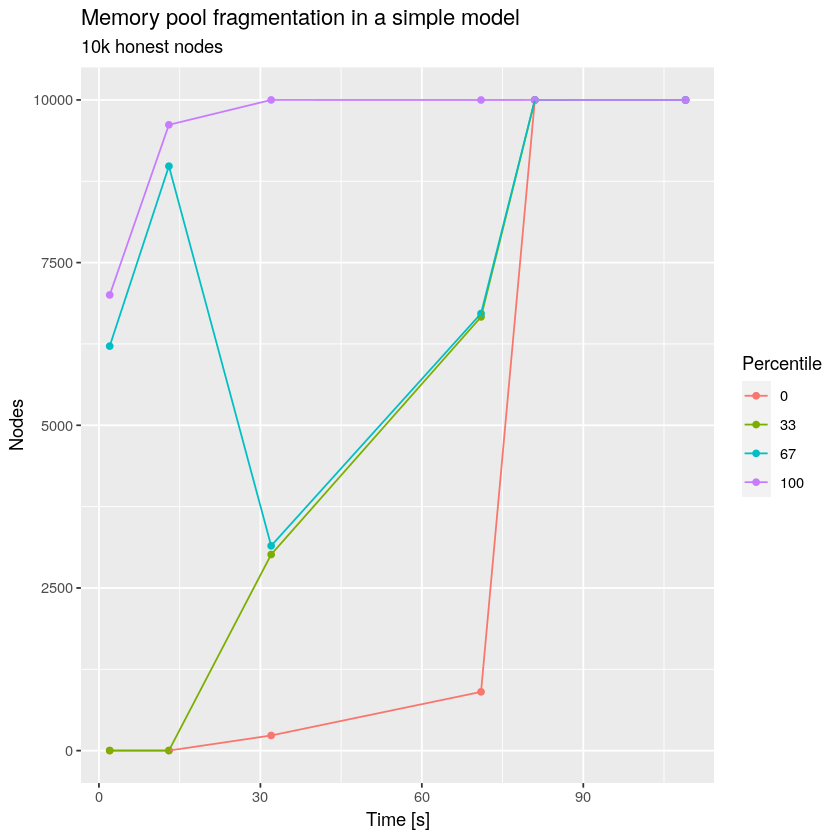

In [9]:
ggplot(
    abstract,
    aes(x=`Time [s]`, y=`Nodes`, color=`Percentile`)
) +
    geom_point() +
    geom_line() +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    )

#### Plot by number of transactions in memory pool

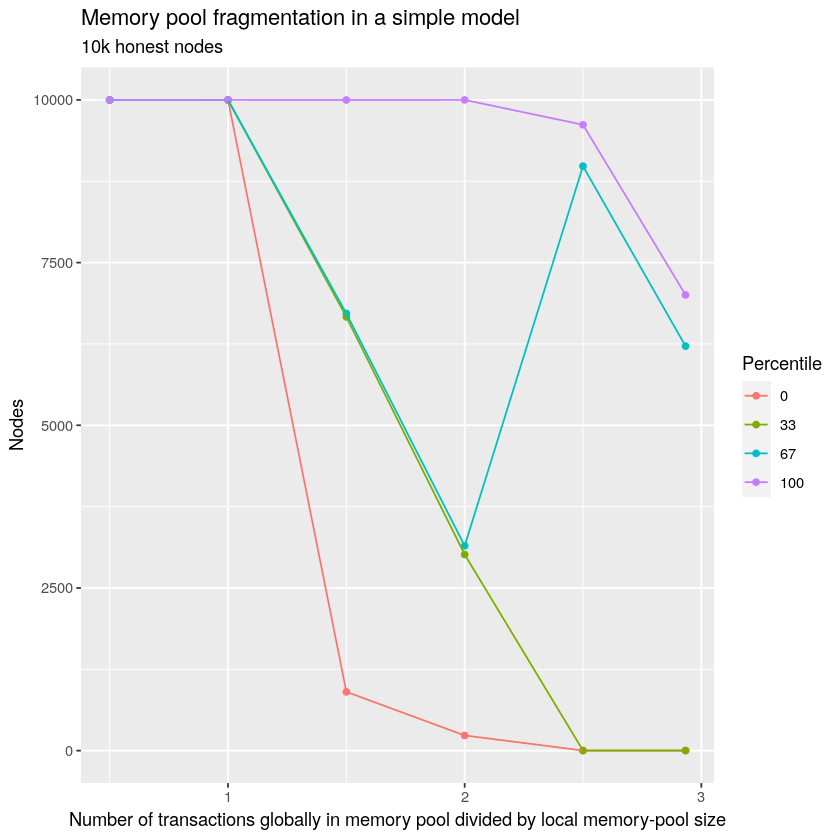

In [10]:
ggplot(
    abstract,
    aes(x=`Txs`/120, y=`Nodes`, color=`Percentile`)
) +
    geom_point() +
    geom_line() +
    xlab("Number of transactions globally in memory pool divided by local memory-pool size") +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    )